In [126]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query('select * from Fires', conn)

## Sampling 10% of the dataset

In [3]:
fires_sample = fires.sample(frac=1/10)
fires_sample.sample(10)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
606465,606466,654319,SFO-TX01430694-10719908,NONFED,ST-NASF,ST/C&L,USTXLAS,Texas Forest Service - Linden Area,TXLAS,Texas Forest Service - Linden Area,None,None,None,None,None,None,None,None,None,1994,2449616.5,264,None,8.0,Children,NaN,NaN,None,3.00,B,32.556250,-94.656250,14.0,MISSING/NOT SPECIFIED,TX,Harrison,203,Harrison,b'\x00\x01\xad\x10\x00\x00\xfc\xff\xff\xff\xff...
393717,393718,427377,SFO-CO0501213,NONFED,ST-NASF,ST/C&L,USCOLJDS,LaJunta District,COLJDS,CSFS-LaJunta District,None,501213,None,None,None,None,None,None,None,2005,2453462.5,92,None,13.0,Missing/Undefined,NaN,NaN,None,0.20,A,38.090930,-102.884028,14.0,MISSING/NOT SPECIFIED,CO,Bent,011,Bent,b'\x00\x01\xad\x10\x00\x00`\xe5\xfa\xeb\x93\xb...
760655,760656,862424,SCHMIDT_4930484,NONFED,ST-AZAZS,ST/C&L,USAZAZS,Arizona State Forestry Division - State Office,AZAZS,Arizona State Forestry Division - State Office,None,None,None,None,None,None,None,None,None,1993,2449152.5,165,1834,13.0,Missing/Undefined,2449152.5,165.0,2000,1.00,B,32.537185,-111.283347,14.0,MISSING/NOT SPECIFIED,AZ,Pinal,021,Pinal,"b'\x00\x01\xad\x10\x00\x00\xe0\xe05\\""\xd2[\xc..."
821784,821785,929111,STATE_MS_69142,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MS Northwest,MSS Northwest District,None,1-6223,None,None,None,None,None,None,None,2007,2454156.5,56,None,7.0,Arson,NaN,NaN,None,5.00,B,33.840300,-89.818600,14.0,MISSING/NOT SPECIFIED,MS,None,None,None,b'\x00\x01\xad\x10\x00\x00X A\xf1ctV\xc0 jM\xf...
1409453,1409454,19105483,SFO-GA-LAU-91-3/25/1995-1310,NONFED,ST-GAGAS,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,None,91,None,None,None,None,None,None,None,1995,2449801.5,84,1310,5.0,Debris Burning,2449801.5,84.0,1414,0.22,A,32.663900,-82.987000,8.0,PRIVATE,GA,Laurens,175,Laurens,b'\x00\x01\xad\x10\x00\x00\xb8I\x0c\x02+\xbfT\...
824481,824482,945604,STATE_MS_85959,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MS East Central,MSS East Central District,None,00-004,None,None,None,None,None,None,None,2000,2451841.5,298,1725,7.0,Arson,NaN,NaN,None,1.00,B,32.827800,-89.580800,14.0,MISSING/NOT SPECIFIED,MS,None,None,None,b'\x00\x01\xad\x10\x00\x00\x10a\xc3\xd3+eV\xc0...
688189,688190,765765,ME_01230098,NONFED,ST-MEMES,ST/C&L,USMEMES,Maine Forest Service,MEMES,Maine Forest Service,None,None,None,None,None,None,None,None,None,2001,2452165.5,256,None,13.0,Missing/Undefined,2452165.5,256.0,None,1.50,B,44.495667,-69.971444,14.0,MISSING/NOT SPECIFIED,ME,KENNEBEC,011,Kennebec,"b'\x00\x01\xad\x10\x00\x00\x94\xebL%,~Q\xc0\x0..."
37237,37238,37425,FS-1479151,FED,FS-FIRESTAT,FS,USIDIPF,Idaho Panhandle National Forest,0104,Idaho Panhandle National Forest,61,7022,EKS5,FISHER,None,None,None,None,None,2009,2455036.5,205,1134,1.0,Lightning,2455038.5,207.0,1730,2.00,B,48.854722,-116.476389,5.0,USFS,ID,21,021,Boundary,"b""\x00\x01\xad\x10\x00\x00\x90\xae\xd3'}\x1e]\..."
1052902,1052903,1182928,TFS_NC_231995,NONFED,ST-NCNCS,ST/C&L,USNCNCS,North Carolina Forest Service,NCNCS108,NCS Region 1 District 8,None,03-009,None,HERMAN DOWLESS FIRE,None,None,None,None,None,2003,2452744.5,105,None,5.0,Debris Burning,NaN,NaN,None,3.00,B,34.416700,-78.550000,14.0,MISSING/NOT SPECIFIED,NC,None,None,None,b'\x00\x01\xad\x10\x00\x0003333\xa3S\xc0(\x1f\...
879882,879883,1002501,SWRA_GA_58365,NONFED,ST-GAGAS,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS28,GAS Unit 28,None,3.5945,None,None,None,None,None,None,None,1999,2451285.5,107,None,5.0,Debris Bur

In [4]:
fires_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188046 entries, 290585 to 1043060
Data columns (total 39 columns):
OBJECTID                      188046 non-null int64
FOD_ID                        188046 non-null int64
FPA_ID                        188046 non-null object
SOURCE_SYSTEM_TYPE            188046 non-null object
SOURCE_SYSTEM                 188046 non-null object
NWCG_REPORTING_AGENCY         188046 non-null object
NWCG_REPORTING_UNIT_ID        188046 non-null object
NWCG_REPORTING_UNIT_NAME      188046 non-null object
SOURCE_REPORTING_UNIT         188046 non-null object
SOURCE_REPORTING_UNIT_NAME    188046 non-null object
LOCAL_FIRE_REPORT_ID          42274 non-null object
LOCAL_INCIDENT_ID             106113 non-null object
FIRE_CODE                     32553 non-null object
FIRE_NAME                     92326 non-null object
ICS_209_INCIDENT_NUMBER       2548 non-null object
ICS_209_NAME                  2548 non-null object
MTBS_ID                       1051 non-null 

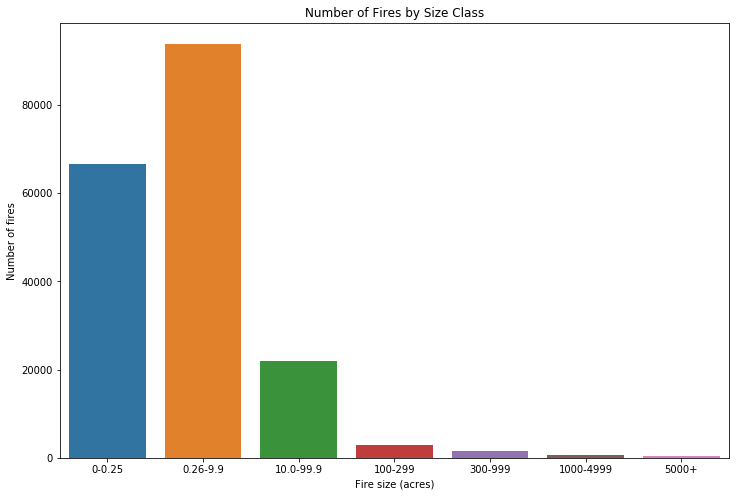

In [5]:
plt.figure(figsize=(12, 8))
fire_size_plot = sns.countplot(x='FIRE_SIZE_CLASS', data=fires_sample, order=['A','B','C','D','E','F','G'])
fire_size_plot.set_title('Number of Fires by Size Class')
fire_size_plot.set_xlabel('Fire size (acres)')
fire_size_plot.set_ylabel('Number of fires')
fire_size_plot.set_xticklabels(['0-0.25', '0.26-9.9', '10.0-99.9', '100-299', '300-999', '1000-4999', '5000+']);

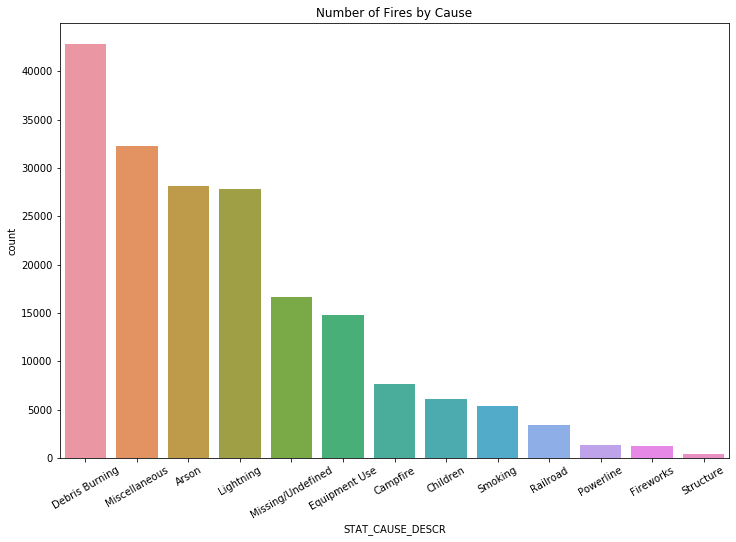

In [6]:
fig = plt.figure(figsize=(12,8))
fire_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR', 
                                data=fires_sample, 
                                order=fires_sample.STAT_CAUSE_DESCR.value_counts().index)
fire_cause_plot.set_title('Number of Fires by Cause')
fire_cause_plot.set_xticklabels(fire_cause_plot.get_xticklabels(), rotation=30);

## Fire cause vs. fire size

A=greater than 0 but less than or equal to 0.25 acres<br />
B=0.26-9.9 acres<br />
C=10.0-99.9 acres<br />
D=100-299 acres<br />
E=300 to 999 acres<br />
F=1000 to 4999 acres<br />
G=5000+ acres

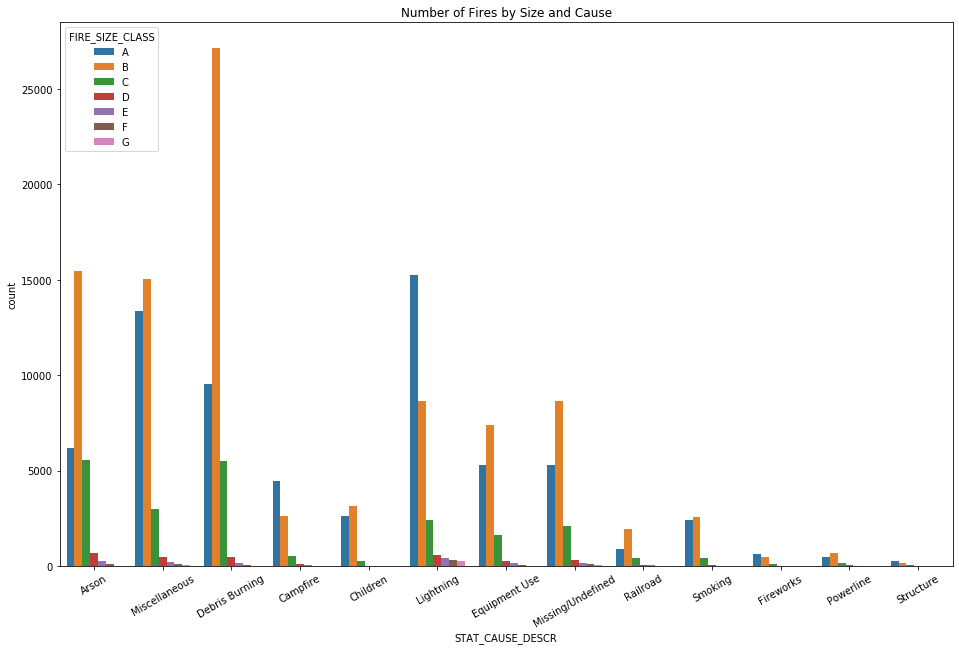

In [50]:
fig = plt.figure(figsize=(16,10))
size_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR',
                                hue='FIRE_SIZE_CLASS',
                                data=fires_sample,
                                hue_order=['A','B','C','D','E','F','G'])
size_cause_plot.set_title('Number of Fires by Size and Cause')
size_cause_plot.set_xticklabels(size_cause_plot.get_xticklabels(), rotation=30);

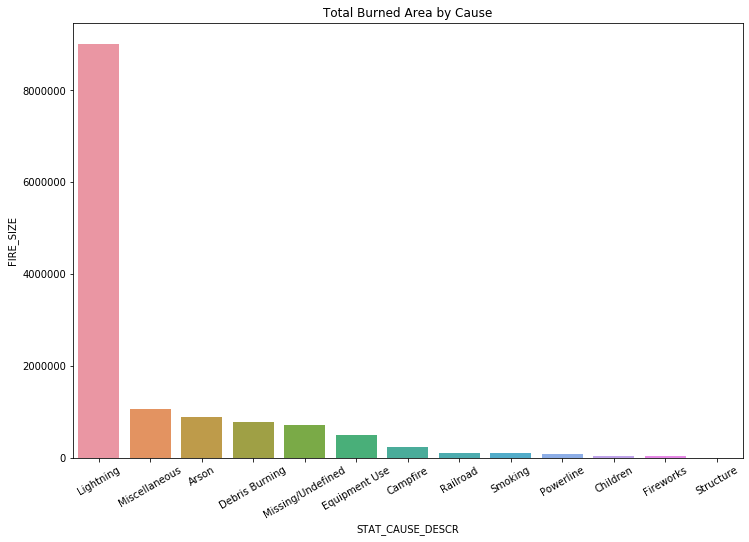

In [10]:
fire_size_by_cause = fires_sample.groupby(['STAT_CAUSE_DESCR'])['FIRE_SIZE'].sum().reset_index()

plt.figure(figsize=(12,8))
fire_size_by_cause_plot = sns.barplot(x='STAT_CAUSE_DESCR', 
                                      y='FIRE_SIZE', 
                                      data=fire_size_by_cause, 
                                      order=fire_size_by_cause.sort_values(by='FIRE_SIZE', ascending=False).STAT_CAUSE_DESCR.tolist())
fire_size_by_cause_plot.set_title('Total Burned Area by Cause')
fire_size_by_cause_plot.set_xticklabels(fire_size_by_cause_plot.get_xticklabels(), rotation=30);

## Explore Other Features

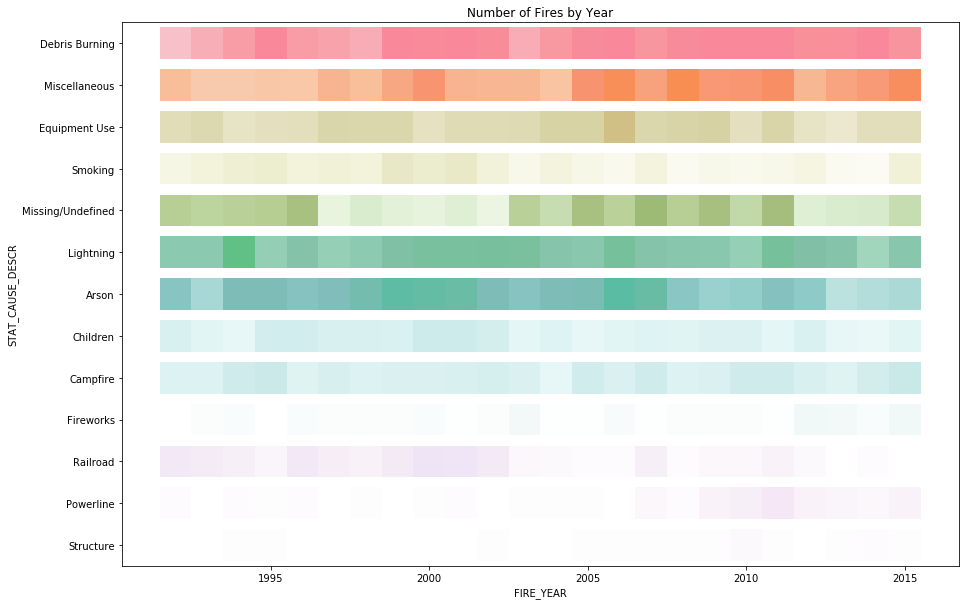

In [114]:
plt.figure(figsize=(15,10))
fire_by_year_plot = sns.stripplot(x='FIRE_YEAR', 
                                  y='STAT_CAUSE_DESCR', 
                                  data=fires.sample(10000), 
                                  size=31.7, 
                                  marker='s', 
                                  alpha=0.01,
                                  jitter=False)
fire_by_year_plot.set_title('Number of Fires by Year');

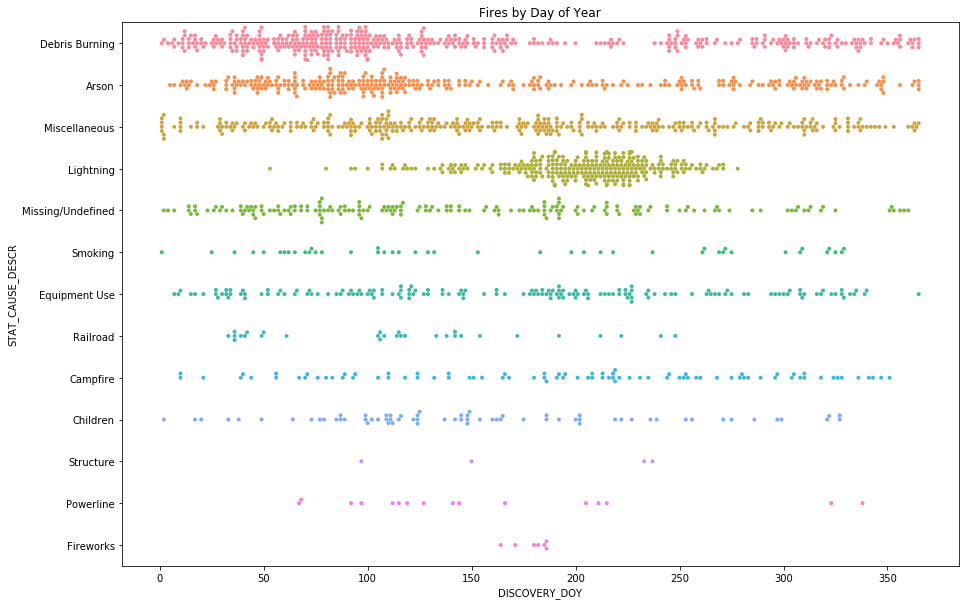

In [138]:
plt.figure(figsize=(15,10))
doy_cause_plot = sns.swarmplot(x='DISCOVERY_DOY', y='STAT_CAUSE_DESCR', data=fires.sample(2000), size=4)
doy_cause_plot.set_title('Fires by Day of Year');

## Select features

In [13]:
features = ['FIRE_YEAR', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
X = fires_sample[features]
y = fires_sample['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Decision Tree

In [121]:
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(train_X, train_y)
dt_prediction = dt_model.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, dt_prediction))

Accuracy: 0.42573783568199947


## Random Forest

In [127]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, rf_prediction))

Accuracy: 0.49978729061419835


## XGBoost

In [15]:
xg_model = XGBClassifier(random_state=1)
xg_model.fit(train_X, train_y)
xg_prediction = xg_model.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, xg_prediction))

Accuracy: 0.45275192767880884


## Compare a sample of the results

In [136]:
pd.DataFrame({'actual_cause': val_y,
              'dt_prediction': dt_prediction,
              'rf_prediction': rf_prediction,
              'xg_prediction': xg_prediction}).sample(20)

,actual_cause,dt_prediction,rf_prediction,xg_prediction
1870095,Debris Burning,Missing/Undefined,Debris Burning,Miscellaneous
54783,Lightning,Lightning,Lightning,Lightning
720848,Missing/Undefined,Arson,Missing/Undefined,Missing/Undefined
108111,Miscellaneous,Miscellaneous,Miscellaneous,Lightning
842123,Arson,Debris Burning,Equipment Use,Debris Burning
313451,Children,Arson,Equipment Use,Miscellaneous
1240537,Debris Burning,Debris Burning,Debris Burning,Debris Burning
1193897,Miscellaneous,Miscellaneous,Miscellaneous,Miscellaneous
267230,Arson,Arson,Miscellaneous,Miscellaneous
726547,Missing/Undefined,Missing/Undefined,Missing/Undefined,Missing/Undefined
